In [22]:
import pandas as pd

df = pd.read_csv("Dados Históricos - Ibovespa.csv")
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,18.07.2025,133.382,135.562,135.562,133.296,"10,07B","-1,61%"
1,17.07.2025,135.565,135.515,135.792,135.016,"6,80B","0,04%"
2,16.07.2025,135.511,135.250,135.641,134.265,"7,83B","0,19%"
3,15.07.2025,135.250,135.298,136.022,134.380,"6,90B","-0,04%"
4,14.07.2025,135.299,136.187,136.187,134.840,"7,33B","-0,65%"
...,...,...,...,...,...,...,...
4949,25.07.2005,24.531,25.388,25.388,24.410,"218,22M","-3,39%"
4950,22.07.2005,25.391,25.834,25.848,25.244,"166,89M","-1,75%"
4951,21.07.2005,25.842,25.706,25.964,25.505,"109,50M","0,53%"
4952,20.07.2005,25.705,25.268,25.795,24.970,"130,63M","1,72%"


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4954 entries, 0 to 4953
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      4954 non-null   object 
 1   Último    4954 non-null   float64
 2   Abertura  4954 non-null   float64
 3   Máxima    4954 non-null   float64
 4   Mínima    4954 non-null   float64
 5   Vol.      4953 non-null   object 
 6   Var%      4954 non-null   object 
dtypes: float64(4), object(3)
memory usage: 271.1+ KB


In [24]:
# Convertemos em data e organizamos por ordem (+ antigo ao + recente)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data').reset_index(drop=True)
df.head()

# Limpeza e formatação dos dados de volume e numéricos
# A coluna 'Vol.' pode estar em formato de string como '12,34M'.
def converter_volume(vol_str):
    vol_str = str(vol_str).strip().upper()
    if 'M' in vol_str:
        return float(vol_str.replace('M', '').replace(',', '.')) * 1_000_000
    elif 'K' in vol_str:
        return float(vol_str.replace('K', '').replace(',', '.')) * 1_000
    elif 'B' in vol_str:
        return float(vol_str.replace('B', '').replace(',', '.')) * 1_000_000_000
    return float(vol_str)

for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    # Remove o ponto de milhar e substitui a vírgula decimal
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

if 'Vol.' in df.columns:
    df['Volume'] = df['Vol.'].apply(converter_volume)
else:
    print("Aviso: Coluna de volume 'Vol.' não encontrada. Features de volume não serão criadas.")
    df['Volume'] = 0

In [25]:
# Criação da Variável Alvo (Target)
# O objetivo é prever se o preço de fechamento de amanhã será maior que o de hoje.
# 1 = Sobe, 0 = Cai ou Fica Igual
df['Fechamento_Amanhã'] = df['Último'].shift(-1)
df['Previsão'] = (df['Fechamento_Amanhã'] > df['Último']).astype(int)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Fechamento_Amanhã,Previsão
0,2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M","-0,20%",119270000.0,25705.0,1
1,2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M","1,72%",130630000.0,25842.0,1
2,2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M","0,53%",109500000.0,25391.0,0
3,2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M","-1,75%",166890000.0,24531.0,0
4,2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M","-3,39%",218220000.0,24868.0,1


In [26]:
# Features

# 1. Variação do dia: Utilizando "Último" - "Abertura"
df['Variação_Dia'] = df['Último'] - df['Abertura']
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Fechamento_Amanhã,Previsão,Variação_Dia
0,2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M","-0,20%",119270000.0,25705.0,1,-41.0
1,2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M","1,72%",130630000.0,25842.0,1,437.0
2,2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M","0,53%",109500000.0,25391.0,0,136.0
3,2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M","-1,75%",166890000.0,24531.0,0,-443.0
4,2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M","-3,39%",218220000.0,24868.0,1,-857.0


In [27]:
# 2. Lag 1: Fechamento do dia anterior
df['Fechamento_Anterior'] = df['Último'].shift(1)
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Fechamento_Amanhã,Previsão,Variação_Dia,Fechamento_Anterior
0,2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M","-0,20%",119270000.0,25705.0,1,-41.0,NaN
1,2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M","1,72%",130630000.0,25842.0,1,437.0,25271.0
2,2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M","0,53%",109500000.0,25391.0,0,136.0,25705.0
3,2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M","-1,75%",166890000.0,24531.0,0,-443.0,25842.0
4,2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M","-3,39%",218220000.0,24868.0,1,-857.0,25391.0


In [28]:
# 3. Média Móvel de 5 Dias
df['Média_5_Dias'] = df['Último'].rolling(15).mean()
df.head()



,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Fechamento_Amanhã,Previsão,Variação_Dia,Fechamento_Anterior,Média_5_Dias
0,2005-07-19,25271.0,25312.0,25312.0,2496.0,"119,27M","-0,20%",119270000.0,25705.0,1,-41.0,NaN,NaN
1,2005-07-20,25705.0,25268.0,25795.0,2497.0,"130,63M","1,72%",130630000.0,25842.0,1,437.0,25271.0,NaN
2,2005-07-21,25842.0,25706.0,25964.0,25505.0,"109,50M","0,53%",109500000.0,25391.0,0,136.0,25705.0,NaN
3,2005-07-22,25391.0,25834.0,25848.0,25244.0,"166,89M","-1,75%",166890000.0,24531.0,0,-443.0,25842.0,NaN
4,2005-07-25,24531.0,25388.0,25388.0,2441.0,"218,22M","-3,39%",218220000.0,24868.0,1,-857.0,25391.0,NaN


In [29]:
df['Retorno_Pct'] = df['Último'].pct_change().shift(-1)
df['Previsão'] = (df['Retorno_Pct'] > 0.005).astype(int)


In [30]:
# Remover os NaN
df = df.dropna()
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Volume,Fechamento_Amanhã,Previsão,Variação_Dia,Fechamento_Anterior,Média_5_Dias,Retorno_Pct
14,2005-08-08,26711.0,26521.0,26985.0,26521.0,"86,05M","0,73%",86050000.0,27291.0,1,190.0,26518.0,24315.533333,0.021714
15,2005-08-09,27291.0,26711.0,27291.0,26711.0,"87,22M","2,17%",87220000.0,27117.0,0,580.0,26711.0,24450.200000,-0.006376
16,2005-08-10,27117.0,27291.0,27606.0,26935.0,"143,98M","-0,64%",143980000.0,26633.0,0,-174.0,27291.0,24544.333333,-0.017849
17,2005-08-11,26633.0,27099.0,27512.0,26494.0,"148,34M","-1,78%",148340000.0,26951.0,1,-466.0,27117.0,24597.066667,0.011940
18,2005-08-12,26951.0,26629.0,26951.0,25734.0,"133,06M","1,19%",133060000.0,27375.0,1,322.0,26633.0,24701.066667,0.015732


In [31]:
# Jogar colunas "Fechamento_Amanhã" e "Previsão" para o final da df
df = df[['Data', 'Último', 'Abertura', 'Variação_Dia', 'Fechamento_Anterior', 'Média_5_Dias', 'Fechamento_Amanhã', 'Previsão']]
df.head()

,Data,Último,Abertura,Variação_Dia,Fechamento_Anterior,Média_5_Dias,Fechamento_Amanhã,Previsão
14,2005-08-08,26711.0,26521.0,190.0,26518.0,24315.533333,27291.0,1
15,2005-08-09,27291.0,26711.0,580.0,26711.0,24450.200000,27117.0,0
16,2005-08-10,27117.0,27291.0,-174.0,27291.0,24544.333333,26633.0,0
17,2005-08-11,26633.0,27099.0,-466.0,27117.0,24597.066667,26951.0,1
18,2005-08-12,26951.0,26629.0,322.0,26633.0,24701.066667,27375.0,1


In [32]:
x = df[['Variação_Dia', 'Fechamento_Anterior', 'Média_5_Dias']]
y = df['Previsão']

In [33]:
# Treino: todos os dias, menos os 30 últimos
x_treino = x[:-30]
y_treino = y[:-30]

In [34]:
# Teste: último dia
x_teste = x[-30:]
y_teste = y[-30:]

In [35]:
# Treinando modelo Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

modelo = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=30)
modelo.fit(x_treino, y_treino)

previsoes = modelo.predict(x_teste)

In [36]:
# Acurácia
acuracia = accuracy_score(y_teste, previsoes)
print(f"Acurácia: {acuracia:.2%}")

Acurácia: 83.33%


In [37]:
# Relatório de desempenho
print(classification_report(y_teste, previsoes))

              precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.86      0.60      0.71        10

    accuracy                           0.83        30
   macro avg       0.84      0.77      0.79        30
weighted avg       0.84      0.83      0.82        30



In [38]:
# Matriz de confusão
print(confusion_matrix(y_teste, previsoes))

[[19  1]
 [ 4  6]]


# MODELO COMPLEMENTADO - COPILOT

In [39]:
import pandas as pd
import numpy as np

# Carregar os dados
df = pd.read_csv("Dados Históricos - Ibovespa.csv")

# Converter datas e ordenar
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df = df.sort_values('Data').reset_index(drop=True)

# Converter colunas numéricas
for col in ['Último', 'Abertura', 'Máxima', 'Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

# Converter volume
def converter_volume(vol_str):
    vol_str = str(vol_str).strip().upper()
    if 'B' in vol_str:
        return float(vol_str.replace('B', '').replace(',', '.')) * 1_000_000_000
    elif 'M' in vol_str:
        return float(vol_str.replace('M', '').replace(',', '.')) * 1_000_000
    elif 'K' in vol_str:
        return float(vol_str.replace('K', '').replace(',', '.')) * 1_000
    return float(vol_str.replace(',', '.'))

df['Volume'] = df['Vol.'].apply(converter_volume)

# Criar variáveis
df['Fechamento_Amanhã'] = df['Último'].shift(-1)
df['Retorno_Pct'] = df['Último'].pct_change().shift(-1)
df['Previsão'] = (df['Retorno_Pct'] > 0.005).astype(int)

df['Variação_Dia'] = df['Último'] - df['Abertura']
df['Fechamento_Anterior'] = df['Último'].shift(1)
df['Média_15_Dias'] = df['Último'].rolling(5).mean()
df['Retorno_5_Dias'] = df['Último'].pct_change(periods=5)
df['Retorno_10_Dias'] = df['Último'].pct_change(periods=10)
df['Volatilidade_5_Dias'] = df['Último'].rolling(5).std()

df = df.dropna()


In [43]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Seleção de features
features = ['Variação_Dia', 'Fechamento_Anterior', 'Média_15_Dias',
            'Retorno_5_Dias', 'Retorno_10_Dias', 'Volatilidade_5_Dias', 'Volume']
x = df[features]
y = df['Previsão']

# Divisão treino/teste
x_treino = x[:-30]
y_treino = y[:-30]
x_teste = x[-30:]
y_teste = y[-30:]

# Grid Search para otimização
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='accuracy')
grid.fit(x_treino, y_treino)
modelo = grid.best_estimator_

# Para verificar a acurácia
previsoes = modelo.predict(x_teste)
acuracia = accuracy_score(y_teste, previsoes)
print(f"Acurácia: {acuracia:.2%}")


Acurácia: 80.00%


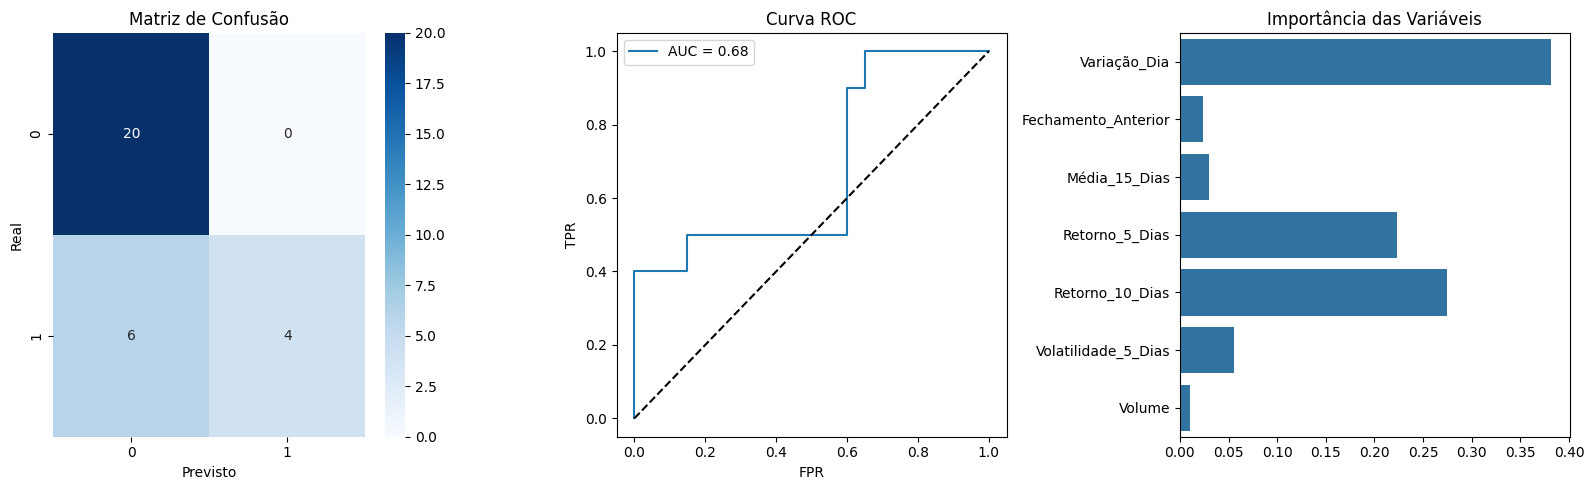

In [41]:
# Visualizações

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Previsões
previsoes = modelo.predict(x_teste)
probs = modelo.predict_proba(x_teste)[:, 1]

# Métricas
acuracia = accuracy_score(y_teste, previsoes)
relatorio = classification_report(y_teste, previsoes)
matriz = confusion_matrix(y_teste, previsoes)
fpr, tpr, _ = roc_curve(y_teste, probs)
roc_auc = auc(fpr, tpr)
importancias = modelo.feature_importances_

# Gráficos
plt.figure(figsize=(16, 5))

# Matriz de confusão
plt.subplot(1, 3, 1)
sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Previsto')
plt.ylabel('Real')

# Curva ROC
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curva ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# Importância das variáveis
plt.subplot(1, 3, 3)
sns.barplot(x=importancias, y=features)
plt.title('Importância das Variáveis')

plt.tight_layout()
plt.show()